In [120]:
from collections import OrderedDict
from glob import glob
import numpy as np
import pandas as pd
from os.path import join
import re
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr

import torch
import torch.nn as nn
from torch import Tensor
from torchmetrics.utilities.checks import _check_same_shape
from torchmetrics import Metric
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

from pismemulator.metrics import AbsoluteError, absolute_error


In [246]:
class PDDEmulator(pl.LightningModule):
    def __init__(
        self,
        n_parameters: int,
        hparams,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters(hparams)
        n_layers = self.hparams.n_layers
        n_hidden = self.hparams.n_hidden

        if isinstance(n_hidden, int):
            n_hidden = [n_hidden] * (n_layers - 1)

        # Inputs to hidden layer linear transformation
        self.l_first = nn.Linear(n_parameters, n_hidden[0])
        self.norm_first = nn.LayerNorm(n_hidden[0])
        self.dropout_first = nn.Dropout(p=0.0)

        models = []
        for n in range(n_layers - 2):
            models.append(
                nn.Sequential(
                    OrderedDict(
                        [
                            ("Linear", nn.Linear(n_hidden[n], n_hidden[n + 1])),
                            ("LayerNorm", nn.LayerNorm(n_hidden[n + 1])),
                            ("Dropout", nn.Dropout(p=0.1)),
                        ]
                    )
                )
            )
        self.dnn = nn.ModuleList(models)
        self.l_last = nn.Linear(n_hidden[-1], 1)

        self.train_ae = AbsoluteError()
        self.test_ae = AbsoluteError()

    def forward(self, x, add_mean=False):
        # Pass the input tensor through each of our operations

        a = self.l_first(x)
        a = self.norm_first(a)
        a = self.dropout_first(a)
        z = torch.relu(a)

        for dnn in self.dnn:
            a = dnn(z)
            z = torch.relu(a) + z

        return self.l_last(z)


    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = parent_parser.add_argument_group("NNEmulator")
        parser.add_argument("--batch_size", type=int, default=128)
        parser.add_argument("--n_hidden", default=128)
        parser.add_argument("--learning_rate", type=float, default=0.01)

        return parent_parser

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), self.hparams.learning_rate, weight_decay=0.0
        )
        # This is an approximation to Doug's version:
        scheduler = {
            "scheduler": ExponentialLR(optimizer, 0.9975, verbose=True),
        }

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, f, o, _ = batch
        f_pred = self.forward(x)
        loss = absolute_error(f_pred, f, o)

        return loss

    def validation_step(self, batch, batch_idx):
        x, f, o, o_0 = batch
        f_pred = self.forward(x)

        self.log("train_loss", self.train_ae(f_pred, f, o))
        self.log("test_loss", self.test_ae(f_pred, f, o_0))

        return {"x": x, "f": f, "f_pred": f_pred, "o": o, "o_0": o_0}

    def validation_epoch_end(self, outputs):

        self.log(
            "train_loss",
            self.train_ae,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        self.log(
            "test_loss",
            self.test_ae,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )


In [247]:
class TorchPDDModel(torch.nn.modules.Module):
    """

    # Copyright (c) 2013--2018, Julien Seguinot <seguinot@vaw.baug.ethz.ch>
    # GNU General Public License v3.0+ (https://www.gnu.org/licenses/gpl-3.0.txt)

    A positive degree day model for glacier surface mass balance

    Return a callable Positive Degree Day (PDD) model instance.

    Model parameters are held as public attributes, and can be set using
    corresponding keyword arguments at initialization time:

    *pdd_factor_snow* : float
        Positive degree-day factor for snow.
    *pdd_factor_ice* : float
        Positive degree-day factor for ice.
    *refreeze_snow* : float
        Refreezing fraction of melted snow.
    *refreeze_ice* : float
        Refreezing fraction of melted ice.
    *temp_snow* : float
        Temperature at which all precipitation falls as snow.
    *temp_rain* : float
        Temperature at which all precipitation falls as rain.
    *interpolate_rule* : [ 'linear' | 'nearest' | 'zero' |
                           'slinear' | 'quadratic' | 'cubic' ]
        Interpolation rule passed to `scipy.interpolate.interp1d`.
    *interpolate_n*: int
        Number of points used in interpolations.
    """

    def __init__(
        self,
        pdd_factor_snow=3,
        pdd_factor_ice=8,
        refreeze_snow=0.0,
        refreeze_ice=0.0,
        temp_snow=0.0,
        temp_rain=2.0,
        interpolate_rule="linear",
        interpolate_n=52,
        *args,
        **kwargs,
    ):
        super().__init__()

        # set pdd model parameters
        self.pdd_factor_snow = pdd_factor_snow
        self.pdd_factor_ice = pdd_factor_ice
        self.refreeze_snow = refreeze_snow
        self.refreeze_ice = refreeze_ice
        self.temp_snow = temp_snow
        self.temp_rain = temp_rain
        self.interpolate_rule = interpolate_rule
        self.interpolate_n = interpolate_n

    def forward(self, temp, prec, stdv=0.0):
        """Run the positive degree day model.

        Use temperature, precipitation, and standard deviation of temperature
        to compute the number of positive degree days, accumulation and melt
        surface mass fluxes, and the resulting surface mass balance.

        *temp*: array_like
            Input near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Input precipitation rate in meter per year.
        *stdv*: array_like (default 0.0)
            Input standard deviation of near-surface air temperature in Kelvin.

        By default, inputs are N-dimensional arrays whose first dimension is
        interpreted as time and as periodic. Arrays of dimensions
        N-1 are interpreted as constant in time and expanded to N dimensions.
        Arrays of dimension 0 and numbers are interpreted as constant in time
        and space and will be expanded too. The largest input array determines
        the number of dimensions N.

        Return the number of positive degree days ('pdd'), surface mass balance
        ('smb'), and many other output variables in a dictionary.
        """

        # ensure numpy arrays
        temp = torch.asarray(temp)
        prec = torch.asarray(prec)
        stdv = torch.asarray(stdv)

        # expand arrays to the largest shape
        maxshape = max(temp.shape, prec.shape, stdv.shape)
        temp = self._expand(temp, maxshape)
        prec = self._expand(prec, maxshape)
        stdv = self._expand(stdv, maxshape)

        # interpolate time-series
        if self.interpolate_n >= 1:
            temp = self._interpolate(temp)
            prec = self._interpolate(prec)
            stdv = self._interpolate(stdv)

        # compute accumulation and pdd
        accu_rate = self.accu_rate(temp, prec)
        inst_pdd = self.inst_pdd(temp, stdv)

        # initialize snow depth, melt and refreeze rates
        snow_depth = torch.zeros_like(temp)
        snow_melt_rate = torch.zeros_like(temp)
        ice_melt_rate = torch.zeros_like(temp)
        snow_refreeze_rate = torch.zeros_like(temp)
        ice_refreeze_rate = torch.zeros_like(temp)

        snow_depth[:-1] = torch.clone(snow_depth[1:])
        snow_depth = snow_depth + accu_rate
        snow_melt_rate, ice_melt_rate = self.melt_rates(snow_depth, inst_pdd)
        snow_depth = snow_depth - snow_melt_rate

        melt_rate = snow_melt_rate + ice_melt_rate
        snow_refreeze_rate = self.refreeze_snow * snow_melt_rate
        ice_refreeze_rate = self.refreeze_ice * ice_melt_rate
        refreeze_rate = snow_refreeze_rate + ice_refreeze_rate
        runoff_rate = melt_rate - refreeze_rate
        inst_smb = accu_rate - runoff_rate

        # output
        return {
            "temp": temp,
            "prec": prec,
            "stdv": stdv,
            "inst_pdd": inst_pdd,
            "accu_rate": accu_rate,
            "snow_melt_rate": snow_melt_rate,
            "ice_melt_rate": ice_melt_rate,
            "melt_rate": melt_rate,
            "snow_refreeze_rate": snow_refreeze_rate,
            "ice_refreeze_rate": ice_refreeze_rate,
            "refreeze_rate": refreeze_rate,
            "runoff_rate": runoff_rate,
            "inst_smb": inst_smb,
            "snow_depth": snow_depth,
            "pdd": self._integrate(inst_pdd),
            "accu": self._integrate(accu_rate),
            "snow_melt": self._integrate(snow_melt_rate),
            "ice_melt": self._integrate(ice_melt_rate),
            "melt": self._integrate(melt_rate),
            "runoff": self._integrate(runoff_rate),
            "refreeze": self._integrate(refreeze_rate),
            "smb": self._integrate(inst_smb),
        }

    def _expand(self, array, shape):
        """Expand an array to the given shape"""
        if array.shape == shape:
            res = array
        elif array.shape == (1, shape[1], shape[2]):
            res = np.asarray([array[0]] * shape[0])
        elif array.shape == shape[1:]:
            res = np.asarray([array] * shape[0])
        elif array.shape == ():
            res = array * torch.ones(shape)
        else:
            raise ValueError(
                "could not expand array of shape %s to %s" % (array.shape, shape)
            )
        return res

    def _integrate(self, array):
        """Integrate an array over one year"""
        return torch.sum(array, axis=0) / (self.interpolate_n - 1)

    def _interpolate(self, array):
        """Interpolate an array through one year."""

        from scipy.interpolate import interp1d

        rule = self.interpolate_rule
        npts = self.interpolate_n
        oldx = (torch.arange(len(array) + 2) - 0.5) / len(array)
        oldy = torch.vstack((array[-1], array, array[0]))
        newx = (torch.arange(npts) + 0.5) / npts  # use 0.0 for PISM-like behaviour
        newy = interp1d(oldx, oldy, kind=rule, axis=0)(newx)

        return torch.from_numpy(newy)

    def inst_pdd(self, temp, stdv):
        """Compute instantaneous positive degree days from temperature.

        Use near-surface air temperature and standard deviation to compute
        instantaneous positive degree days (effective temperature for melt,
        unit degrees C) using an integral formulation (Calov and Greve, 2005).

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *stdv*: array_like
            Standard deviation of near-surface air temperature in Kelvin.
        """

        # compute positive part of temperature everywhere
        positivepart = torch.greater(temp, 0) * temp

        # compute Calov and Greve (2005) integrand, ignoring division by zero
        normtemp = temp / (torch.sqrt(torch.tensor(2)) * stdv)
        calovgreve = stdv / torch.sqrt(torch.tensor(2) * torch.pi) * torch.exp(
            -(normtemp**2)
        ) + temp / 2 * torch.erfc(-normtemp)

        # use positive part where sigma is zero and Calov and Greve elsewhere
        teff = torch.where(stdv == 0.0, positivepart, calovgreve)

        # convert to degree-days
        return teff * 365.242198781

    def accu_rate(self, temp, prec):
        """Compute accumulation rate from temperature and precipitation.

        The fraction of precipitation that falls as snow decreases linearly
        from one to zero between temperature thresholds defined by the
        `temp_snow` and `temp_rain` attributes.

        *temp*: array_like
            Near-surface air temperature in degrees Celcius.
        *prec*: array_like
            Precipitation rate in meter per year.
        """

        # compute snow fraction as a function of temperature
        reduced_temp = (self.temp_rain - temp) / (self.temp_rain - self.temp_snow)
        snowfrac = torch.clip(reduced_temp, 0, 1)

        # return accumulation rate
        return snowfrac * prec

    def melt_rates(self, snow, pdd):
        """Compute melt rates from snow precipitation and pdd sum.

        Snow melt is computed from the number of positive degree days (*pdd*)
        and the `pdd_factor_snow` model attribute. If all snow is melted and
        some energy (PDD) remains, ice melt is computed using `pdd_factor_ice`.

        *snow*: array_like
            Snow precipitation rate.
        *pdd*: array_like
            Number of positive degree days.
        """

        # parse model parameters for readability
        ddf_snow = self.pdd_factor_snow / 1e3
        ddf_ice = self.pdd_factor_ice / 1e3

        # compute a potential snow melt
        pot_snow_melt = ddf_snow * pdd

        # effective snow melt can't exceed amount of snow
        snow_melt = torch.minimum(snow, pot_snow_melt)

        # ice melt is proportional to excess snow melt
        ice_melt = (pot_snow_melt - snow_melt) * ddf_ice / ddf_snow

        # return melt rates
        return (snow_melt, ice_melt)


In [248]:
from SALib.sample import saltelli
from pyDOE import lhs
from scipy.stats.distributions import truncnorm, gamma, uniform, randint
method = "lhs"
n_prior_samples = 100
np.random.seed(2)

distributions = {
    "f_snow": uniform(
        loc=2.0, scale=4.0
    ), 
    "f_ice": uniform(
        loc=3.0, scale=9
    ),  # uniform between 3 and 3.5  AS16 best value: 3.25
    "refreeze": uniform(loc=0, scale=1.0),  # uniform between 0.25 and 0.95
}
# Names of all the variables
keys = [x for x in distributions.keys()]

# Describe the Problem
problem = {"num_vars": len(keys), "names": keys, "bounds": [[0, 1]] * len(keys)}

# Generate uniform samples (i.e. one unit hypercube)
if method == "saltelli":
    unif_sample = saltelli.sample(problem, n_prior_samples, calc_second_order=False)
elif method == "lhs":
    unif_sample = lhs(len(keys), n_prior_samples)
else:
    print(f"Method {method} not available")

# To hold the transformed variables
dist_sample = np.zeros_like(unif_sample)

# Now transform the unit hypercube to the prescribed distributions
# For each variable, transform with the inverse of the CDF (inv(CDF)=ppf)
for i, key in enumerate(keys):
    dist_sample[:, i] = distributions[key].ppf(unif_sample[:, i])

# Save to CSV file using Pandas DataFrame and to_csv method
header = keys
# Convert to Pandas dataframe, append column headers, output as csv
df = pd.DataFrame(data=dist_sample, columns=header)


In [320]:
# Copyright (C) 2021 Andy Aschwanden, Douglas C Brinkerhoff
#
# This file is part of pism-emulator.
#
# PISM-EMULATOR is free software; you can redistribute it and/or modify it under the
# terms of the GNU General Public License as published by the Free Software
# Foundation; either version 3 of the License, or (at your option) any later
# version.
#
# PISM-EMULATOR is distributed in the hope that it will be useful, but WITHOUT ANY
# WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
# FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more
# details.
#
# You should have received a copy of the GNU General Public License
# along with PISM; if not, write to the Free Software
# Foundation, Inc., 51 Franklin St, Fifth Floor, Boston, MA  02110-1301  USA

import torch
from torch import Tensor
from torchmetrics.utilities.checks import _check_same_shape
from torchmetrics import Metric


def _absolute_error_update(
    preds: Tensor, target: Tensor, omegas: Tensor) -> Tensor:
    _check_same_shape(preds, target)
    diff = torch.abs(preds - target)
    sum_abs_error = torch.sum(diff * diff, axis=1)
    absolute_error = torch.sum(sum_abs_error * omegas.squeeze())
    return absolute_error


def _absolute_error_compute(absolute_error) -> Tensor:
    return absolute_error


def absolute_error(
    preds: Tensor, target: Tensor, omegas: Tensor
) -> Tensor:
    """
    Computes squared absolute error
    Args:
        preds: estimated labels
        target: ground truth labels
        omegas: weights
        area: area of each cell
    Return:
        Tensor with absolute error
    Example:
        >>> x = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]]).T
        >>> y = torch.tensor([[0, 1, 2, 1], [2, 3, 4, 4]]).T
        >>> o = torch.tensor([0.25, 0.25, 0.3, 0.2])
        >>> a = torch.tensor([0.25, 0.25])
        >>> absolute_error(x, y, o, a)
        tensor(0.4000)
    """
    sum_abs_error = _absolute_error_update(preds, target, omegas)
    return _absolute_error_compute(sum_abs_error)


class AbsoluteError(Metric):
    def __init__(self, compute_on_step: bool = True, dist_sync_on_step=False):
        # call `self.add_state`for every internal state that is needed for the metrics computations
        # dist_reduce_fx indicates the function that should be used to reduce
        # state from multiple processes
        super().__init__(
            compute_on_step=compute_on_step, dist_sync_on_step=dist_sync_on_step
        )

        self.add_state("sum_abs_error", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds: Tensor, target: Tensor, omegas: Tensor):
        """
        Update state with predictions and targets, and area.
        Args:
            preds: Predictions from model
            target: Ground truth values
            omegas: Weights
            area: Area of each cell
        """
        sum_abs_error = _absolute_error_update(preds, target, omegas)
        self.sum_abs_error += sum_abs_error

    def compute(self):
        """
        Computes absolute error over state.
        """
        return _absolute_error_compute(self.sum_abs_error)

    @property
    def is_differentiable(self):
        return True


In [321]:
class PDDDataModule(pl.LightningDataModule):
    def __init__(
        self,
        X,
        Y,
        omegas,
        omegas_0,
        batch_size: int = 128,
        train_size: float = 0.9,
        num_workers: int = 0,
    ):
        super().__init__()
        self.X = X
        self.Y = Y
        self.omegas = omegas
        self.omegas_0 = omegas_0
        self.batch_size = batch_size
        self.train_size = train_size
        self.num_workers = num_workers

    def setup(self, stage: str = None):

        all_data = TensorDataset(self.X, self.Y, self.omegas, self.omegas_0)
        self.all_data = all_data

        training_data, val_data = train_test_split(
            all_data, train_size=self.train_size, random_state=0
        )
        self.training_data = training_data
        self.test_data = training_data

        self.val_data = val_data
        train_all_loader = DataLoader(
            dataset=all_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.train_all_loader = train_all_loader
        val_all_loader = DataLoader(
            dataset=all_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.val_all_loader = val_all_loader
        train_loader = DataLoader(
            dataset=training_data,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )
        self.train_loader = train_loader
        self.test_loader = train_loader
        val_loader = DataLoader(
            dataset=val_data,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )
        self.val_loader = val_loader

    def prepare_data(self, **kwargs):
        pass
    
    def train_dataloader(self):
        return self.train_loader

    def validation_dataloader(self):
        return self.val_loader


In [327]:
    n = 25
    m = 12

    lx = ly = 750000
    x = np.linspace(-lx, lx, n)
    y = np.linspace(-ly, ly, n)
    t = (np.arange(12) + 0.5) / 12

    # assign temperature and precipitation values
    (yy, xx) = np.meshgrid(y, x)
    temp = np.zeros((m, n, n), dtype=float)
    prec = np.zeros((m, n, n), dtype=float)
    stdv = np.zeros((m, n, n), dtype=float)
    for i in range(len(t)):
        temp[i] = -10 * yy / ly - 5 * np.cos(i * 2 * np.pi / 12)
        prec[i] = xx / lx * (np.sign(xx) - np.cos(i * 2 * np.pi / 12))
        stdv[i] = (2 + xx / lx - yy / ly) * (1 - np.cos(i * 2 * np.pi / 12))

    T_obs = temp.reshape(1, -1)
    P_obs = prec.reshape(1, -1)
    std_dev = stdv.reshape(1, -1)

    X = []
    Y = []
    for k, row in df.iterrows():   
        pdd = TorchPDDModel(
            pdd_factor_snow=row["f_snow"],
            pdd_factor_ice=row["f_ice"],
            refreeze_snow=row["refreeze"],
            refreeze_ice=row["refreeze"],
            n_interpolate=1,
        )
        result = pdd(T_obs, P_obs, std_dev)

        M_obs = result["melt"]
        Y.append(M_obs)
        x = torch.from_numpy(np.hstack((T_obs.T, P_obs.T, std_dev.T)))
        X.append(x)

    X = torch.vstack(X).type(torch.FloatTensor)
    Y = torch.hstack(Y).type(torch.FloatTensor).reshape(-1, 1)
    n_samples, n_parameters = X.shape

In [328]:
    import os
    from scipy.stats import dirichlet

    model_index = 0
    torch.manual_seed(0)
    pl.seed_everything(0)
    np.random.seed(model_index)
    emulator_dir = "pddemulator"

    if not os.path.isdir(emulator_dir):
        os.makedirs(emulator_dir)
        os.makedirs(os.path.join(emulator_dir, "emulator"))


Global seed set to 0


In [ ]:
    print(f"Training model {model_index}")
    omegas = torch.Tensor(dirichlet.rvs(np.ones(n_samples))).T
    omegas = omegas.type(torch.FloatTensor)
    omegas_0 = torch.ones_like(omegas) / len(omegas)
    area = torch.ones_like(omegas)
    train_size = 1.0
    num_workers = 1
    hparams = {"n_layers": 5, "n_hidden": 128, "batch_size": 128, "learning_rate": 0.01}
    
    if train_size == 1.0:
        data_loader = PDDDataModule(X, Y, omegas, omegas_0, num_workers=num_workers)
    else:
        data_loader = PDDDataModule(
            X, Y, omegas, omegas_0, train_size=train_size, num_workers=num_workers
        )

    data_loader.setup()
    e = PDDEmulator(
        n_parameters,
        hparams,
    )
    trainer = pl.Trainer(
        deterministic=True,
        num_sanity_val_steps=0,
        max_epochs=10,
    )
    if train_size == 1.0:
        train_loader = data_loader.train_all_loader
        val_loader = data_loader.val_all_loader
    else:
        train_loader = data_loader.train_loader
        val_loader = data_loader.val_loader

    trainer.fit(e, train_loader, val_loader)
    torch.save(e.state_dict(), f"{emulator_dir}/emulator/emulator_{model_index}.h5")


Training model 0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type          | Params
------------------------------------------------
0 | l_first       | Linear        | 512   
1 | norm_first    | LayerNorm     | 256   
2 | dropout_first | Dropout       | 0     
3 | dnn           | ModuleList    | 50.3 K
4 | l_last        | Linear        | 129   
5 | train_ae      | AbsoluteError | 0     
6 | test_ae       | AbsoluteError | 0     
------------------------------------------------
51.2 K    Trainable params
0         Non-trainable params
51.2 K    Total params
0.205     Total estimated model params size (MB)


Adjusting learning rate of group 0 to 1.0000e-02.


Training: -1it [00:00, ?it/s]

In [173]:
Y.reshape(-1, 1).shape

torch.Size([10000, 1])

In [317]:
Y.shape

torch.Size([30000])

In [139]:
n_samples

39

In [144]:
torch.from_numpy?

In [158]:
X.type_as?

In [159]:
X.type?

epoch:1000,loss=2.701
epoch:2000,loss=2.107
epoch:3000,loss=1.855
epoch:4000,loss=1.684
epoch:5000,loss=1.516
epoch:6000,loss=1.345
epoch:7000,loss=1.182
epoch:8000,loss=1.036
epoch:9000,loss=0.908
epoch:10000,loss=0.797
epoch:11000,loss=0.702
epoch:12000,loss=0.621
epoch:13000,loss=0.552
epoch:14000,loss=0.493
epoch:15000,loss=0.442
epoch:16000,loss=0.399
epoch:17000,loss=0.362
epoch:18000,loss=0.330
epoch:19000,loss=0.303
epoch:20000,loss=0.279
epoch:21000,loss=0.257
epoch:22000,loss=0.238
epoch:23000,loss=0.221
epoch:24000,loss=0.205
epoch:25000,loss=0.192
epoch:26000,loss=0.180
epoch:27000,loss=0.168
epoch:28000,loss=0.158
epoch:29000,loss=0.148
epoch:30000,loss=0.139
epoch:31000,loss=0.130
epoch:32000,loss=0.122
epoch:33000,loss=0.115
epoch:34000,loss=0.108
epoch:35000,loss=0.102
epoch:36000,loss=0.097
epoch:37000,loss=0.092
epoch:38000,loss=0.087
epoch:39000,loss=0.083
epoch:40000,loss=0.079
epoch:41000,loss=0.075
epoch:42000,loss=0.071
epoch:43000,loss=0.068
epoch:44000,loss=0.0

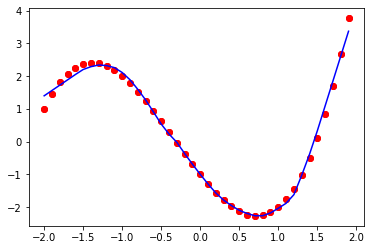

In [260]:
import numpy as np
import matplotlib.pyplot as plt
X = np.array([*range(-20,20)],dtype=np.float32)
X = X*0.1
y = [x**3+ x**2 -3*x -1 for x in X]
plt.plot(X,y,'ro')

import torch
import torch.nn as nn
import torch.nn.functional as F

X_t = torch.tensor(X,dtype=torch.float32)
y_t = torch.tensor(y,dtype=torch.float32)
X_t = X_t.view(X_t.shape[0],1)
y_t = y_t.view(y_t.shape[0],1)

class func_simulator(nn.Module):
    def __init__(self):
        super(func_simulator,self).__init__()
        self.l1 = nn.Linear(1,128)
        self.l2 = nn.Linear(128,10)
        self.l3 = nn.Linear(10,1)
    
    def forward(self,x):
        out = F.relu(self.l1(x))
        out = F.relu(self.l2(out))
        out = self.l3(out)
        return out

learning_rate,num_epochs    = 0.0001,100000
model                       = func_simulator()
loss                        = nn.MSELoss()
gradient                    = torch.optim.SGD(model.parameters(),lr=learning_rate)
# train on batch
for epoch in range(num_epochs):
    y_pred = model.forward(X_t)
    l = loss(y_pred,y_t)
    l.backward()
    gradient.step()
    gradient.zero_grad()

    if(epoch+1)%1000==0:
        print(f'epoch:{epoch+1},loss={l.item():.3f}')

# test the result, use detach to detrack the parameters. 
predicted = model(X_t).detach().numpy()
plt.plot(X_t,y_t,'ro')
plt.plot(X_t,predicted,'b')
plt.show()